In [13]:
import numpy as np
from numpy import pi
import h5py
from matplotlib import pyplot as plt
from qutip  import *
import qutip as qt
from scipy.optimize import curve_fit

In [14]:
def H_CPT(del_c, del_p, Omega_c, Omega_p, chi,kappa,Gamma,dephase):
    # Hamiltonian form is given by equation 7.3 from Novokov's thesis
    
    # del_x: detuning from the transitions
    # Omega_x: Rabi frequency for each transitions
    # chi is the dispersive shift, and note that the cavity freq difference when qubit is at |e> or |g> is 2*chi  
    # Qubit subspace: 2x2, Cavity subspace: N+1 x N+1
    N=9
    g =basis(2,0)
    e = basis(2,1)
    
    term1 = -(del_c+2*chi)*tensor(g*g.dag(),num(N+1))
    term2 = -del_p*tensor(e*e.dag() ,qeye(N+1))-del_c *(tensor(e*e.dag(),num(N+1))-tensor(e*e.dag(),qeye(N+1)))
    term3 = (Omega_c/2)*tensor(e*e.dag(),create(N+1))
    term4 = qt.tensor(qt.basis(2,1), qt.basis(N+1,1))*(tensor(qt.basis(2,0), qt.basis(N+1,0)).dag()) * Omega_p/2
    H = term1 + term2 + term3 + term4 + (term3+term4).dag() 
    
    A_cav   = tensor(qeye(2),destroy(N+1))*np.sqrt(kappa)
    A_relax   = tensor(destroy(2),qeye(N+1))*np.sqrt(Gamma)
    A_dephase = tensor(sigmaz(), qeye(N+1)) * (dephase)**0.5
    return H,[A_cav,A_relax,A_dephase]

In [15]:
def CPT_Spectrum(del_list, Omega_c, Omega_p):
    N=9
    del_control=0
    chi = -1.1* (2*np.pi) #dispersive shift
    kappa = 7.9 * (2*np.pi)
    Gamma = 0.11 * (2*np.pi)#T1=10us  T2=5us dephase = 1/(5e-6)-1/2*(10e-6)
    dephase = 0.1* (2*np.pi)
    control="hi"
    spec = np.zeros(len( del_list), dtype=np.float64)
    spec_real = np.zeros(len( del_list), dtype=np.float64)
    spec_imag = np.zeros(len( del_list), dtype=np.float64)
    pop_g0 = np.zeros(len( del_list), dtype=np.float64)
    pop_e0 = np.zeros(len( del_list), dtype=np.float64)
    pop_e1 = np.zeros(len( del_list), dtype=np.float64)
    
    def spectrum(H, c_ops):
        rho_ss= steadystate(H, c_ops,solver='scipy')
        spec = rho_ss[N+1, (N+2)].imag
        pop_g0 = rho_ss[0, 0].real
        pop_e0 =expect(num(2) ,ptrace(rho_ss,0))#rho_ss[N+1, (N+1)].real
        pop_e1 =rho_ss[N+2, N+2].real
        return spec, pop_g0, pop_e0, pop_e1
    if control=="Probe":
        for i, del_c in enumerate(del_list):
            H ,c_ops = H_CPT(del_c,del_control, Omega_c, Omega_p, chi,kappa,Gamma,dephase)
            spec[i], pop_g0[i], pop_e0[i], pop_e1[i] = spectrum(H ,c_ops)
    
    else:
        for i, del_p in enumerate(del_list):
            H ,c_ops = H_CPT(del_control,del_p, Omega_c, Omega_p, chi,kappa,Gamma,dephase)
            spec[i], pop_g0[i], pop_e0[i], pop_e1[i] = spectrum(H ,c_ops)
            
    return pop_e0#,spec,pop_g0,pop_e1

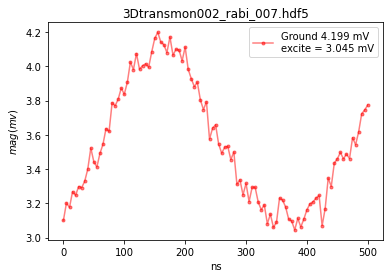

In [16]:
def func(x,a,b,c,d,t1):
    return a * np.cos(b*(x-c)) * np.exp(-(x-c)/t1) + d

directory = 'C:\\Users\\user\\SynologyDrive\\DESKTOP-V6JLHQU\\C\\Users\\cluster\\Labber\\Data\\2022\\08\\Data_0817'
fname = '3Dtransmon002_rabi_007.hdf5'
path = directory + '\\' + fname

# Read data and plot
with h5py.File(path,'r') as hf:
    #print ('Keys of this file: \n', list(hf.keys()))
    #print (list(data_group.keys()))
    data = hf['Data/Data']
    # Initializer,RF_Qubit
    #power = hf['Step config/Initializer - Power/Step items'][0][2]
    #fd    = hf['Step config/Initializer - Frequency/Step items'][0][2]
    power = hf['Step config/RF_Qubit - Power/Step items'][0][2]
    fd    = hf['Step config/RF_Qubit - Frequency/Step items'][0][2]
    # Check logger comment for time duration
    N = data.shape[0]
    """ INPUT dt """
    #dt = 8
    #time = np.linspace(0, (N-1) * dt, N)
    time = data[:,0,0]*1e+9
    dt = (time[1]-time[0])
    
    # Extract I, Q data
    demod_real = data[:,1,0]
    demod_imag = data[:,2,0]
    demod_mag = np.abs(demod_real + 1j*demod_imag) * 1e+6

fitted = demod_mag/1000
ground = max(fitted)
excite = min(fitted)
time_nice = np.linspace(time[0], time[-1], 201)
label = "Ground {:.3f} mV".format(max(fitted))+"\nexcite = {:.3f} mV".format(min(fitted))
plt.plot(time, fitted , 'r.-', alpha = 0.5,label = label)

plt.title(fname)
plt.xlabel('ns')
plt.ylabel('$mag (m v)$')
plt.legend()
plt.show()

data shape: (573, 4, 12)


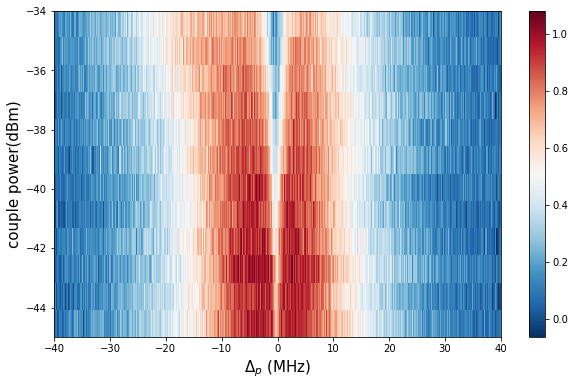

In [17]:
directory = 'C:\\Users\\user\\SynologyDrive\\DESKTOP-V6JLHQU\\C\\Users\\cluster\\Labber\\Data\\2022\\08\\Data_0817'
fname = '3Dtransmon002_CPT_fix_couple_population_008.hdf5'
path = directory + '\\' + fname
idx=3

with h5py.File(path,'r') as hf:
    #print(hf.keys())
    raw_data = np.copy(hf["Data"]["Data"])
    print("data shape:", raw_data.shape)
    
resonace=5307.4

e_pop = np.zeros((12,573))
for i in range(12):
    freq = raw_data[:,0,i] * 1e-6
    Data = raw_data[:,2,i] + 1j*raw_data[:,3,i]
    mag  = np.abs(Data) * 1e+3 
    e_pop[i]=(ground-mag)/(ground-excite)

extent = -40, 40, -45, -34
plt.figure(figsize=(10,6))
plt.imshow(e_pop, origin="lower", aspect = "auto", cmap = "RdBu_r", interpolation = "None", extent=extent) 
plt.xlabel(r"$\Delta_p$ (MHz)",fontsize=15)
plt.ylabel("couple power(dBm)",fontsize=15)
plt.colorbar()

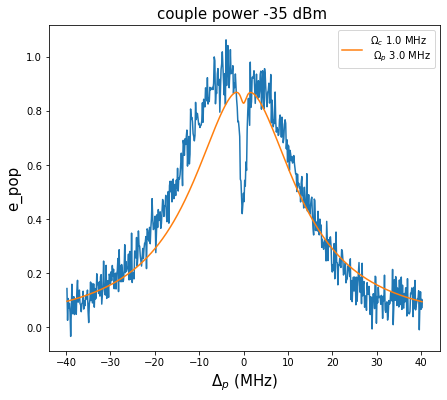

In [22]:
del_control=0
chi = -1.1* (2*np.pi) #dispersive shift

Omega_c = 1* (2*np.pi)
Omega_p = 3* (2*np.pi)

kappa = 7 #* (2*np.pi)
Gamma = 0.1 #* (2*np.pi)#T1=10us  T2=5us dephase = 1/(5e-6)-1/2*(10e-6)

del_list = 2*pi*2*(freq-5307.4)#2*pi*np.linspace(start, end, point)
z = np.zeros(573)
z= CPT_Spectrum(del_list, Omega_c, Omega_p)
plt.figure(figsize=(7,6))
plt.xlabel(r"$\Delta_p$ (MHz)",fontsize=15)
plt.ylabel("e_pop",fontsize=15)
plt.title("couple power -35 dBm ",fontsize=15)
plt.plot(2*(freq-5307.4),e_pop[5])
plt.plot(del_list/(2*pi), z,label="$\Omega_c$ {:.1f} MHz".format(Omega_c/(2*np.pi))+\
        "\n $\Omega_p$ {:.1f} MHz".format(Omega_p/(2*np.pi)))
plt.legend()

In [19]:
guess = [3.5* (2*np.pi), 
         3.4* (2*np.pi)]
qopt, qcov = curve_fit(CPT_Spectrum, del_list, e_pop[5], guess) 
plt.plot(del_list/(2*pi), CPT_Spectrum(del_list, qopt[0],qopt[1]))
plt.plot(2*(freq-5307.4),e_pop[5])
(qopt[0]/(2*np.pi),qopt[1]/(2*np.pi))

KeyboardInterrupt: 

(4.085243820004229, 6.5615235405725105)

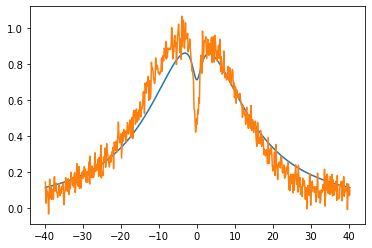

In [217]:
guess = [3.5* (2*np.pi), 
         3.4* (2*np.pi)]
qopt, qcov = curve_fit(CPT_Spectrum, del_list, e_pop[5], guess) 
plt.plot(del_list/(2*pi), CPT_Spectrum(del_list, qopt[0],qopt[1]))
plt.plot(2*(freq-5307.4),e_pop[5])
(qopt[0]/(2*np.pi),qopt[1]/(2*np.pi))

(11.98208393181896, 7.1469792274073125)

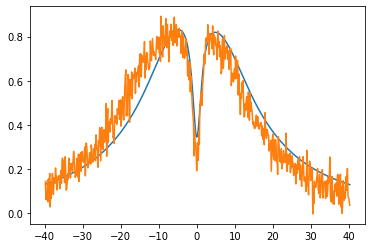

In [178]:
guess = [3.5* (2*np.pi), 
         3.4* (2*np.pi)]
qopt, qcov = curve_fit(CPT_Spectrum, del_list, e_pop[9], guess) 
plt.plot(del_list/(2*pi), CPT_Spectrum(del_list, qopt[0],qopt[1]))
plt.plot(2*(freq-5307.4),e_pop[9])
(qopt[0]/(2*np.pi),qopt[1]/(2*np.pi))